In [1]:
import os
import pandas as pd
import seaborn as sns

import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import FontProperties

import scipy
import scipy.stats as stats

In [2]:
# constants
GRID_SIZE = 5.0
LABEL_COLOR = "black"
TICK_COLOR = "black"
FONT_SIZE = 14

# general
mpl.rcParams["text.color"] = LABEL_COLOR
mpl.rcParams["font.family"] = "monospace"
mpl.rcParams["font.size"] = FONT_SIZE
mpl.rcParams["font.style"] = "italic"
mpl.rcParams["font.weight"] = "light"

# label
mpl.rcParams["axes.labelcolor"] = LABEL_COLOR
mpl.rcParams["axes.labelsize"] = FONT_SIZE
mpl.rcParams["axes.labelweight"] = "light"

# ticks
mpl.rcParams["xtick.color"] = TICK_COLOR
mpl.rcParams["ytick.color"] = TICK_COLOR
mpl.rcParams["xtick.labelsize"] = FONT_SIZE
mpl.rcParams["ytick.labelsize"] = FONT_SIZE

In [3]:
def heatmap(
    evaluation_results: pd.DataFrame, 
    x_positions: np.ndarray, 
    y_positions: np.ndarray, 
    delta: float = 0.5
):
    evaluation_results_list = evaluation_results.to_dict("records")
    heatmap_values = list()

    for i in range(len(x_positions) - 1):
        for j in range(len(y_positions) - 1):
            heatmap_values.append({
                "x": round(x_positions[i], 2),
                "y": round(y_positions[j], 2),
                "r": 0.0
            })

    for i in range(len(heatmap_values)):
        x_min = heatmap_values[i]["x"]
        x_max = x_min + delta

        y_min = heatmap_values[i]["y"]
        y_max = y_min + delta

        rewards = list()
        for j in range(len(evaluation_results_list)):
            x_eval = evaluation_results_list[j]["x_position"]
            y_eval = evaluation_results_list[j]["y_position"]
            r_eval = evaluation_results_list[j]["r"]

            if (x_min <= x_eval < x_max) and (y_min <= y_eval < y_max):
                rewards.append(r_eval)
                pass

        heatmap_values[i]["r"] = np.mean(rewards)

    heatmap_values_df = pd.DataFrame.from_dict(heatmap_values)
    heatmap_values_df["x"] = heatmap_values_df["x"] + round(delta / 2, 2)
    heatmap_values_df["y"] = heatmap_values_df["y"] + round(delta / 2, 2)

    heatmap = heatmap_values_df.pivot(index="y", columns=["x"], values="r")
    heatmap.sort_index(ascending=False, inplace=True)

    return heatmap

In [4]:
def merge_csvs_to_df(csv_paths: list) -> pd.DataFrame:
    merged_data = list()

    for csv in csv_paths: 
        temp = pd.read_csv(csv).to_dict("records")
        merged_data.extend(temp)
        pass

    return pd.DataFrame.from_records(merged_data)

In [5]:
# constants
random_seeds = [2878, 5069, 5073, 5250, 4420]

# ranges
x_positions = np.linspace(-GRID_SIZE, GRID_SIZE, num=21)
y_positions = np.linspace(-GRID_SIZE, GRID_SIZE, num=21)
delta = x_positions[1] - x_positions[0]

In [6]:
rl_squared_csvs = list()
auto_dr_csvs = list()

for seed in random_seeds:
    rl_squared_csvs.append(f"../data/rl_squared/{int(GRID_SIZE)}x{int(GRID_SIZE)}/seed-{seed}.csv")
    auto_dr_csvs.append(f"../data/auto_dr/{int(GRID_SIZE)}x{int(GRID_SIZE)}/seed-{seed}.csv")
    pass

# csvs
rl_squared_results = merge_csvs_to_df(rl_squared_csvs)
auto_dr_results = merge_csvs_to_df(auto_dr_csvs)

In [7]:
rl_squared_heatmap = heatmap(rl_squared_results, x_positions, y_positions, delta)

x_ticks = ["{:.2f}".format(round(t, 2)) if t % 0.75 == 0 else "" for t in rl_squared_heatmap.columns.tolist()]
y_ticks = ["{:.2f}".format(round(t, 2)) if t % 0.75 == 0 else "" for t in rl_squared_heatmap.index.tolist()]

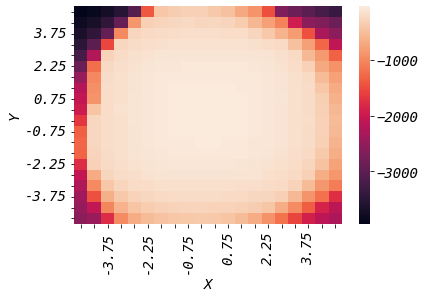

In [8]:
ax = sns.heatmap(rl_squared_heatmap, xticklabels=x_ticks, yticklabels=y_ticks)
ax.set(xlabel="X", ylabel="Y")
plt.xticks(rotation=90)
plt.show()

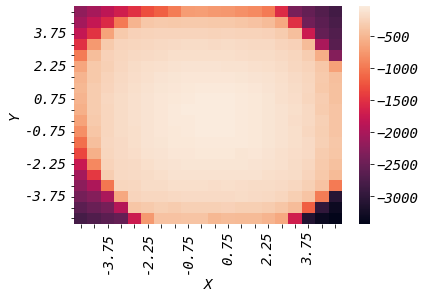

In [9]:
auto_dr_heatmap = heatmap(auto_dr_results, x_positions, y_positions, delta)
ax = sns.heatmap(auto_dr_heatmap, xticklabels=x_ticks, yticklabels=y_ticks)

ax.set(xlabel="X", ylabel="Y")
plt.xticks(rotation=90)
plt.show()

In [10]:
def significance_heatmap(
    rl2_results: pd.DataFrame, 
    rl2_adr_results: pd.DataFrame, 
    x_positions: np.ndarray, 
    y_positions: np.ndarray,
    delta: float = 0.5
):
    heatmap_values = list()

    for i in range(len(x_positions) - 1):
        for j in range(len(y_positions) - 1):
            heatmap_values.append({
                "x": round(x_positions[i], 2),
                "y": round(y_positions[j], 2),
                "pdf_shift": 0.0,
            })

    # p-values
    rl2_results_list = rl2_results.to_dict("records")
    rl2_adr_results_list = rl2_adr_results.to_dict("records")

    for i in range(len(heatmap_values)):
        x_min = heatmap_values[i]["x"]
        x_max = x_min + delta

        y_min = heatmap_values[i]["y"]
        y_max = y_min + delta

        # RL2
        rewards_rl2 = list()
        for j in range(len(rl2_results_list)):
            x_eval = rl2_results_list[j]["x_position"]
            y_eval = rl2_results_list[j]["y_position"]
            r_eval = rl2_results_list[j]["r"]

            if (x_min <= x_eval < x_max) and (y_min <= y_eval < y_max):
                rewards_rl2.append(r_eval)
                pass

        # RL2-ADR
        rewards_rl2_adr = list()
        for j in range(len(rl2_adr_results_list)):
            x_eval = rl2_adr_results_list[j]["x_position"]
            y_eval = rl2_adr_results_list[j]["y_position"]
            r_eval = rl2_adr_results_list[j]["r"]

            if (x_min <= x_eval < x_max) and (y_min <= y_eval < y_max):
                rewards_rl2_adr.append(r_eval)
                pass

        # tests the null hypothesis that the population median of both groups is the same.
        p_value = stats.kruskal(rewards_rl2, rewards_rl2_adr).pvalue
        if p_value < 0.05:
            # if this is positive -> rl2-adr is better
            # if this is negative -> rl2 is better
            diff_normalized = (np.median(rewards_rl2_adr) - np.median(rewards_rl2)) / abs(np.median(rewards_rl2_adr))
        else:
            # stub, distributions are the same.
            diff_normalized = 0.0

        heatmap_values[i]["pdf_shift"] = diff_normalized
        continue

    heatmap_values_df = pd.DataFrame.from_dict(heatmap_values)
    heatmap_values_df["x"] = heatmap_values_df["x"] + round(delta / 2, 2)
    heatmap_values_df["y"] = heatmap_values_df["y"] + round(delta / 2, 2)

    heatmap = heatmap_values_df.pivot(index="y", columns=["x"], values="pdf_shift")
    heatmap.sort_index(ascending=False, inplace=True)

    return heatmap, heatmap_values_df

In [11]:
pdf_shift_heatmap, heatmap_values_df = significance_heatmap(rl_squared_results, auto_dr_results, x_positions, y_positions,  delta)

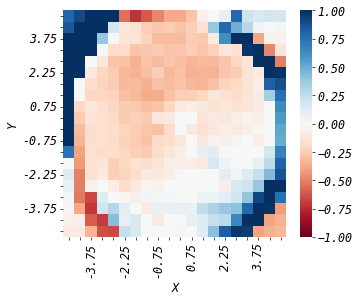

In [12]:
fig = plt.figure(figsize = (6, 5), dpi=60)
ax = sns.heatmap(
    pdf_shift_heatmap, 
    cmap=sns.color_palette("RdBu", as_cmap=True),
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    vmin=-1.0,
    vmax=1.0
)

ax.set(xlabel="X", ylabel="Y")
ax.xaxis.label.set_color(LABEL_COLOR)
ax.yaxis.label.set_color(LABEL_COLOR)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [13]:
ood_rl2_rewards = rl_squared_results[
    ((rl_squared_results["x_position"] > 3.0) | (rl_squared_results["x_position"] < -3.0)) &
    ((rl_squared_results["y_position"] > 3.0) | (rl_squared_results["y_position"] < -3.0))
]
ood_adr_rewards = auto_dr_results[
    ((auto_dr_results["x_position"] > 3.0) | (auto_dr_results["x_position"] < -3.0)) &
    ((auto_dr_results["y_position"] > 3.0) | (auto_dr_results["y_position"] < -3.0))
]

rewards_data_ood = pd.DataFrame()
rewards_data_ood["RL2-ADR"] = ood_adr_rewards["r"]
rewards_data_ood["RL2"] = ood_rl2_rewards["r"]

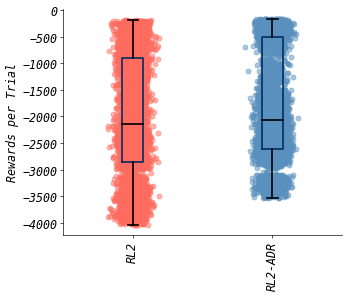

In [14]:
# boxplot
vals, names, xs = [],[],[]

for i, col in enumerate(['RL2', 'RL2-ADR']):
    vals.append(rewards_data_ood[col].values)
    names.append(col)
    # adds jitter to the data points - can be adjusted
    xs.append(np.random.normal(i + 1, 0.05, rewards_data_ood[col].values.shape[0]))
    continue

fig = plt.figure(figsize = (6, 5), dpi=60)
ax  = fig.add_subplot(111)

box_plot = ax.boxplot(
    vals, 
    labels=names, 
    whiskerprops={'linewidth': 2},    
    capprops={'linewidth': 2},
    boxprops={'color':'#002e63', 'linewidth': 2},
    flierprops={'marker': 'o', 'linewidth': 2, 'markersize': 1, 'markerfacecolor': 'none', 'markeredgecolor':'#002e63'},
    medianprops={'linewidth': 2, 'color':'black'}
)

palette = ['#fe6b5f', '#5990bd']

for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.5, color=c)
    continue


# label
ax.set_ylabel('Rewards per Trial')
ax.xaxis.label.set_color(LABEL_COLOR)
ax.yaxis.label.set_color(LABEL_COLOR)
plt.xticks(rotation=90)
sns.despine()
plt.show()

# format
plt.show()

In [15]:
stats.kruskal(rewards_data_ood["RL2"], rewards_data_ood["RL2-ADR"]).pvalue

2.074803019619303e-39

In [16]:
np.median(rewards_data_ood["RL2-ADR"]), np.median(rewards_data_ood["RL2"])

(-2062.481425642535, -2134.933323044018)